# Evaluation of Lorenz GAN Models

The goal of this notebook is to evaluate the quality of the representation of the Lorenz 96 GAN parameterization.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import keras.backend as K
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from keras.models import load_model
from lorenz_gan.gan import Interpolate1D, ConcreteDropout
from lorenz_gan.submodels import load_ann_model
import pandas as pd
from scipy.stats import expon, lognorm
import pickle
from matplotlib.colors import LogNorm
from matplotlib import rc

Using TensorFlow backend.


In [2]:
def normalize_data(data, scaling_values=None):
    """
    Normalize each channel in the 4 dimensional data matrix independently.

    Args:
        data: 4-dimensional array with dimensions (example, y, x, channel/variable)
        scaling_values: pandas dataframe containing mean and std columns

    Returns:
        normalized data array, scaling_values
    """
    normed_data = np.zeros(data.shape, dtype=data.dtype)
    scale_cols = ["mean", "std"]
    if scaling_values is None:
        scaling_values = pd.DataFrame(np.zeros((data.shape[-1], len(scale_cols)), dtype=np.float32),
                                      columns=scale_cols)
        for i in range(data.shape[-1]):
            scaling_values.loc[i, ["mean", "std"]] = [data[:, :, i].mean(), data[:, :, i].std()]
    for i in range(data.shape[-1]):
        normed_data[:, :, i] = (data[:, :, i] - scaling_values.loc[i, "mean"]) / scaling_values.loc[i, "std"]
    return normed_data, scaling_values


def unnormalize_data(normed_data, scaling_values):
    """
    Re-scale normalized data back to original values

    Args:
        normed_data: normalized data
        scaling_values: pandas dataframe of mean and standard deviation from normalize_data

    Returns:
        Re-scaled data
    """
    data = np.zeros(normed_data.shape, dtype=normed_data.dtype)
    for i in range(normed_data.shape[-1]):
        data[:, :, i] = normed_data[:, :, i] * scaling_values.loc[i, "std"] + scaling_values.loc[i, "mean"]
    return data

def fit_condition_distributions(train_cond_data):
    """
    Calculate the scale parameter for the exponential distribution of correlated conditional variables
    for the Lorenz 96 model in time.

    Args:
        train_cond_data: array of conditioning values where the first column is the current X, and each
            other column is a lagged X value

    Returns:
        array of scale values
    """
    train_cond_exp_scale = np.zeros(train_cond_data.shape[1] - 1)
    for i in range(1, train_cond_data.shape[1]):
        train_cond_exp_scale[i - 1] = expon.fit(np.abs(train_cond_data[:, 0] - train_cond_data[:, i]), floc=0)[1]
    return train_cond_exp_scale


def generate_random_condition_data(batch_size, num_cond_inputs, train_cond_scale):
    """
    Generate correlated conditional random numbers to train the generator network.

    Args:
        batch_size: number of random samples
        num_cond_inputs: number of conditional inputs
        train_cond_scale: exponential distribution scale values

    Returns:

    """
    batch_cond_data = np.zeros((batch_size, num_cond_inputs, 1))
    batch_cond_data[:, 0, 0] = np.random.normal(size=batch_size)
    for t in range(1, train_cond_scale.size + 1):
        batch_cond_data[:, t , 0] = batch_cond_data[:, 0, 0] + \
                                    np.random.choice([-1, 1], size=batch_size) * expon.rvs(loc=0,
                                                                                           scale=train_cond_scale[t-1],
                                                                                           size=batch_size)
    return batch_cond_data

Load generator model

In [3]:
gan_samples = xr.open_dataset("../exp_20/gan_gen_patches_0000_epoch_0010.nc")
patches = gan_samples["gen_samples"][:, :, 0].values
gan_samples.close()

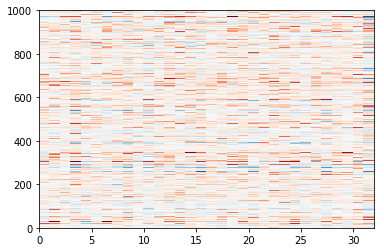

In [4]:
plt.pcolormesh(patches, vmin=-2, vmax=2, cmap="RdBu_r")

(array([   7.,   23.,  128.,  555.,  193.,   61.,   22.,    7.,    3.,    1.]),
 array([-0.91971093, -0.64610658, -0.37250223, -0.09889788,  0.17470647,
         0.44831082,  0.72191517,  0.99551952,  1.26912388,  1.54272823,
         1.81633258]),
 <a list of 10 Patch objects>)

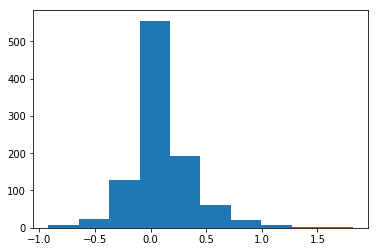

In [5]:
plt.hist(patches[:, 0])

(array([   4.,   10.,   40.,  154.,  296.,  292.,  140.,   52.,    8.,    4.]),
 array([-16.57688141, -12.4942522 ,  -8.411623  ,  -4.3289938 ,
         -0.24636459,   3.83626461,   7.91889381,  12.00152302,
         16.08415222,  20.16678143,  24.24941063]),
 <a list of 10 Patch objects>)

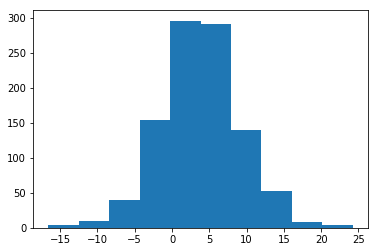

In [6]:
plt.hist(patches.sum(axis=1))

In [9]:
gan_loss = pd.read_csv("../exp_20/gan_loss_history_0000.csv", index_col="Time")
gan_loss["Epoch_Batch"] = gan_loss["Epoch"].values * gan_loss["Batch"].max() + gan_loss["Batch"].values
gan_loss["Epoch_Batch"] = gan_loss["Epoch_Batch"] / gan_loss["Epoch_Batch"].max() * gan_loss["Epoch"].max()

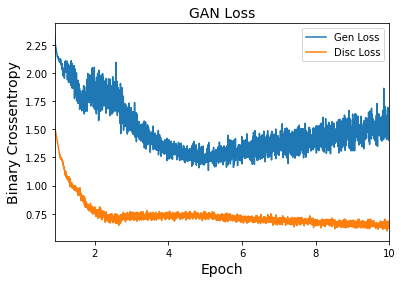

In [10]:

gan_loss[["Gen Loss", "Disc Loss"]].rolling(1).mean().plot(x=gan_loss["Epoch_Batch"].values)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Binary Crossentropy", fontsize=14)
plt.title("GAN Loss", fontsize=14)
plt.savefig("../exp_20/gan_loss_ts.png", dpi=200, bbox_inches="tight")

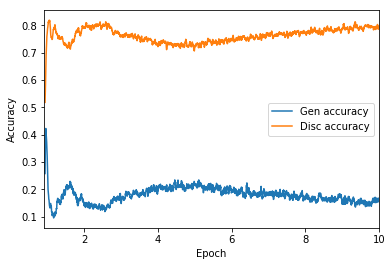

In [11]:
gan_loss[["Gen accuracy", "Disc accuracy"]].rolling(10).mean().plot(x=gan_loss["Epoch_Batch"].values)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

## Evaluate Generator Model

In [4]:
epoch = 10
gen_model = load_model("../exp_u/gan_generator_0003_epoch_{0:04d}.h5".format(epoch), 
                       custom_objects={"Interpolate1D": Interpolate1D,
                                       "ConcreteDropout": ConcreteDropout})

In [8]:
sess = K.get_session()

In [13]:
gen_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 4)             0                                            
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 4, 1)          0           input_2[0][0]                    
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 4, 64)         384         reshape_1[0][0]                  
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 4, 64)         0           conv1d_1[0][0]                   
___________________________________________________________________________________________

In [70]:
sess.run(gen_model.layers[10].p)

0.30814365

In [25]:
rvals = np.random.normal(size=(1, 8))

In [5]:
combined_data = pd.read_csv("../exp_20/lorenz_combined_output.csv")
y_cols = combined_data.columns[combined_data.columns.str.contains("Y")]
x_cols = combined_data.columns[combined_data.columns.str.contains("X")]
x_cols = ["X_t", 'U_t']
print(y_cols)
print(x_cols)

Index(['Y_0', 'Y_1', 'Y_2', 'Y_3', 'Y_4', 'Y_5', 'Y_6', 'Y_7', 'Y_8', 'Y_9',
       'Y_10', 'Y_11', 'Y_12', 'Y_13', 'Y_14', 'Y_15', 'Y_16', 'Y_17', 'Y_18',
       'Y_19', 'Y_20', 'Y_21', 'Y_22', 'Y_23', 'Y_24', 'Y_25', 'Y_26', 'Y_27',
       'Y_28', 'Y_29', 'Y_30', 'Y_31'],
      dtype='object')
['X_t', 'U_t']


In [6]:
x_norm, x_scaling = normalize_data(np.expand_dims(combined_data[x_cols].values, axis=-1))
y_norm, y_scaling = normalize_data(np.expand_dims(combined_data[y_cols].values, axis=-1))


In [8]:
pred_func = K.function(gen_model.input + [K.learning_phase()], [gen_model.output])
gan_norm = pred_func([x_norm[:,:,0] , np.random.normal(size=(x_norm.shape[0], 8)), True])[0]
gan_y = unnormalize_data(gan_norm, y_scaling)

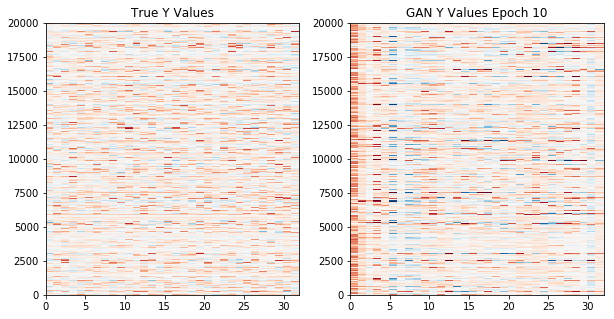

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].pcolormesh(combined_data[y_cols].values[20000:40000], vmin=-2, vmax=2, cmap="RdBu_r")
axes[0].set_title("True Y Values")
axes[1].pcolormesh(gan_y[20000:40000, :, 0], vmin=-2, vmax=2, cmap="RdBu_r")
axes[1].set_title("GAN Y Values Epoch {0}".format(epoch))
plt.savefig("../exp_20/gan_y_vals_epoch_{0}.png".format(epoch), bbox_inches="tight", dpi=200)

In [25]:
combined_data[y_cols].max().max()

2.3562127692406492

(-3, 3)

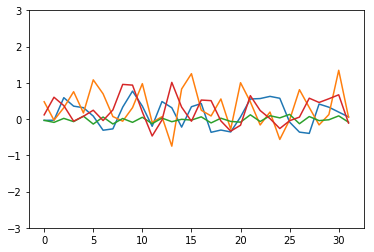

In [34]:
plt.plot(combined_data[y_cols].values[5000])
plt.plot(combined_data[y_cols].values[53000])
plt.plot(combined_data[y_cols].values[3000])
plt.plot(combined_data[y_cols].values[12450])


plt.ylim(-3, 3)

In [47]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
matplotlib.font_manager

['/Library/Fonts/Trebuchet MS.ttf',
 '/System/Library/Fonts/SFCompactText-Medium.otf',
 '/Library/Fonts/Arial Black.ttf',
 '/usr/X11/lib/X11/fonts/TTF/luxisbi.ttf',
 '/usr/X11/lib/X11/fonts/OTF/SyrCOMMardinBold.otf',
 '/Library/Fonts/STIXGeneralBol.otf',
 '/Library/Fonts/STIXSizThreeSymBol.otf',
 '/usr/X11/lib/X11/fonts/OTF/SyrCOMBatnan.otf',
 '/Library/Fonts/Times New Roman.ttf',
 '/Library/Fonts/Ayuthaya.ttf',
 '/System/Library/Fonts/SFCompactText-HeavyItalic.otf',
 '/System/Library/Fonts/SFNSDisplayCondensed-Black.otf',
 '/System/Library/Fonts/Apple Braille Outline 6 Dot.ttf',
 '/System/Library/Fonts/SFCompactRounded-Black.otf',
 '/usr/X11/lib/X11/fonts/OTF/SyrCOMBatnanBold.otf',
 '/System/Library/Fonts/SFCompactText-Heavy.otf',
 '/usr/X11/lib/X11/fonts/TTF/VeraMoBd.ttf',
 '/usr/X11/lib/X11/fonts/OTF/SyrCOMTurAbdin.otf',
 '/usr/X11/lib/X11/fonts/TTF/VeraMoBI.ttf',
 '/usr/X11/lib/X11/fonts/OTF/SyrCOMTalada.otf',
 '/Library/Fonts/Webdings.ttf',
 '/System/Library/Fonts/Apple Braille Ou

In [57]:
set([f.name for f in matplotlib.font_manager.fontManager.ttflist])

{'.Keyboard',
 '.LastResort',
 '.SF Compact Display',
 '.SF Compact Rounded',
 '.SF Compact Text',
 '.SF NS Display Condensed',
 '.SF NS Text Condensed',
 'Andale Mono',
 'Apple Braille',
 'Apple Chancery',
 'Apple Symbols',
 'AppleGothic',
 'AppleMyungjo',
 'Arial',
 'Arial Black',
 'Arial Narrow',
 'Arial Rounded MT Bold',
 'Arial Unicode MS',
 'Ayuthaya',
 'Big Caslon',
 'Bitstream Vera Sans',
 'Bitstream Vera Sans Mono',
 'Bitstream Vera Serif',
 'Bodoni 72 Smallcaps',
 'Bodoni Ornaments',
 'Bradley Hand',
 'Brush Script MT',
 'Chalkduster',
 'Comic Sans MS',
 'Courier New',
 'DIN Alternate',
 'DIN Condensed',
 'DejaVu Sans',
 'DejaVu Sans Display',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'DejaVu Serif Display',
 'Diwan Thuluth',
 'East Syriac Adiabene',
 'East Syriac Ctesiphon',
 'Estrangelo Antioch',
 'Estrangelo Edessa',
 'Estrangelo Midyat',
 'Estrangelo Nisibin',
 'Estrangelo Nisibin Outline',
 'Estrangelo Quenneshrin',
 'Estrangelo Talada',
 'Estrangelo TurAbdin',
 'Farisi',
 

In [68]:
rc('font',**{'family':'Arial'})

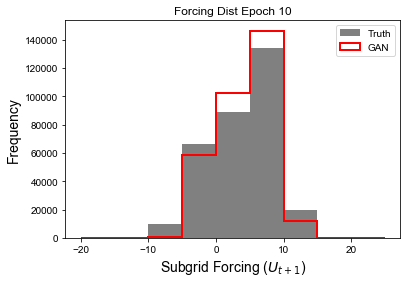

In [70]:
plt.hist(combined_data[y_cols].sum(axis=1).values, bins=np.arange(-20, 30, 5), color="gray", label="Truth")
plt.hist(gan_y[:, :, 0].sum(axis=1), bins=np.arange(-20, 30, 5), histtype='step', lw=2, label="GAN", color="red")
plt.legend()
plt.xlabel("Subgrid Forcing ($U_{t+1}$)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Forcing Dist Epoch {0}".format(epoch))
#plt.gca().set_yscale("log")
plt.savefig("../exp_20/gan_subgrid_hist.png", dpi=200, bbox_inches="tight")

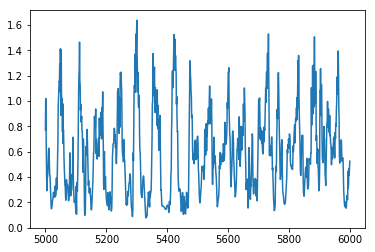

In [41]:
plt.plot(combined_data[y_cols].abs().max(axis=1)[5000:6000])

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None
/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


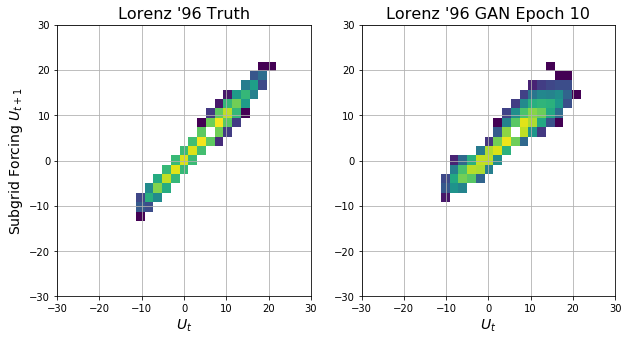

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
_ = axes[0].hist2d(combined_data["U_t"], combined_data[y_cols].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
                                                                                   np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
axes[0].set_title("Lorenz '96 Truth", fontsize=16)
_ = axes[1].hist2d(combined_data["U_t"], gan_y[:, :, 0].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
                                                                           np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
axes[1].set_title("Lorenz '96 GAN Epoch {0}".format(epoch), fontsize=16)
axes[0].set_xlabel("$U_t$", fontsize=14)
axes[1].set_xlabel("$U_t$", fontsize=14)
axes[0].grid()
axes[1].grid()
axes[0].set_ylabel("Subgrid Forcing $U_{t+1}$", fontsize=14)
plt.savefig("../exp_20/gan_u_u1_hist_epoch_{0}.png".format(epoch), dpi=200, bbox_inches="tight")

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None
/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


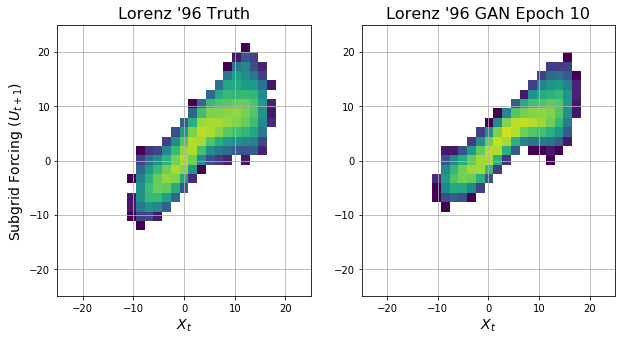

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
_ = axes[0].hist2d(combined_data["X_t"], combined_data[y_cols].sum(axis=1), bins=[np.linspace(-25, 25, 30), 
                                                                                   np.linspace(-25, 25, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
axes[0].set_title("Lorenz '96 Truth", fontsize=16)
_ = axes[1].hist2d(combined_data["X_t"], gan_y[:, :, 0].sum(axis=1), bins=[np.linspace(-25, 25, 30), 
                                                                           np.linspace(-25, 25, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
axes[1].set_title("Lorenz '96 GAN Epoch {0}".format(epoch), fontsize=16)
axes[0].set_xlabel("$X_t$", fontsize=14)
axes[1].set_xlabel("$X_t$", fontsize=14)
axes[0].grid()
axes[1].grid()
axes[0].set_ylabel("Subgrid Forcing ($U_{t+1}$)", fontsize=14)
plt.savefig("../exp_20/gan_x_u_hist_epoch_{0}.png".format(epoch), dpi=200, bbox_inches="tight")

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


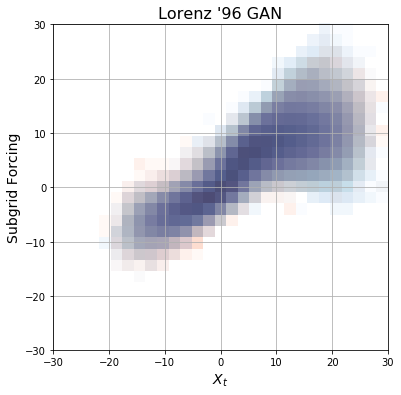

In [20]:
plt.figure(figsize=(6, 6))
_ = plt.hist2d(combined_data["X_t"], combined_data[y_cols].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
               np.linspace(-30, 30, 30)], cmin=1, cmax=20000, norm=LogNorm(1, 20000), cmap="Reds", alpha=0.6)

_ = plt.hist2d(combined_data["X_t"], gan_y[:, :, 0].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
               np.linspace(-30, 30, 30)], cmap="Blues", cmin=1, cmax=20000, norm=LogNorm(1, 20000), alpha=0.6)
plt.grid()
plt.title("Lorenz '96 GAN", fontsize=16)
plt.xlabel("$X_t$", fontsize=14)
plt.ylabel("Subgrid Forcing", fontsize=14)

In [24]:
y_data = combined_data[y_cols].values

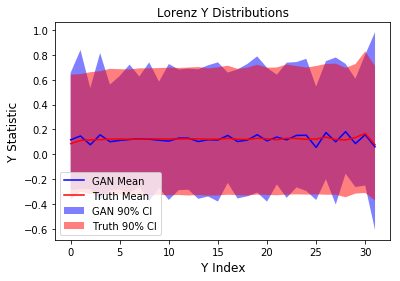

In [25]:
plt.fill_between(np.arange(32), np.percentile(gan_y[:, :, 0], 95, axis=0), 
                 np.percentile(gan_y[:, :, 0], 5, axis=0), alpha=0.5, label="GAN 90% CI", facecolor="blue")
plt.plot(gan_y[:, :, 0].mean(axis=0), label="GAN Mean", color="blue")
plt.fill_between(np.arange(32), np.percentile(y_data, 95, axis=0), 
                 np.percentile(y_data, 5, axis=0), alpha=0.5, facecolor="red", label="Truth 90% CI")
plt.plot(y_data.mean(axis=0), label="Truth Mean", color="red")
plt.legend(loc=3, fontsize=10)
plt.xlabel("Y Index", fontsize=12)
plt.ylabel("Y Statistic", fontsize=12)
plt.title("Lorenz Y Distributions")
plt.savefig("../exp_u/lorenz_y_dist.png", dpi=200, bbox_inches="tight")

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


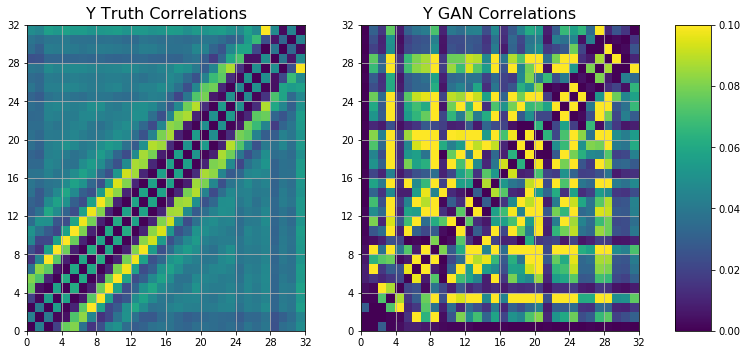

In [27]:
from matplotlib.colors import LogNorm
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(0.05, 0.05, 0.9, 0.9)
cax = fig.add_axes([0.95, 0.05, 0.05, .85])
truth_corr = np.corrcoef(y_data.T) **2
truth_corr[np.diag_indices(truth_corr.shape[0])] = np.nan
gan_corr = np.corrcoef(gan_y[:, :, 0].T)**2
gan_corr[np.diag_indices(truth_corr.shape[0])] = np.nan
pc = axes[0].pcolormesh(truth_corr, vmin=0, vmax=0.1)
axes[1].pcolormesh(gan_corr, vmin=0, vmax=0.1)
axes[0].set_title("Y Truth Correlations", fontsize=16)
axes[0].set_xticks(np.linspace(0, 32, 9))
axes[1].set_xticks(np.linspace(0, 32, 9))
axes[0].set_yticks(np.linspace(0, 32, 9))
axes[1].set_yticks(np.linspace(0, 32, 9))
axes[0].grid()
axes[1].grid()
axes[1].set_title("Y GAN Correlations", fontsize=16)
plt.colorbar(pc, cax=cax)
plt.savefig("../exp_20/y_gan_correlations.png", dpi=200, bbox_inches="tight")

## Evaluate Lorenz GAN Forecast

The plots below show the different Lorenz GAN forecasts and how they compare with the truth run.

In [2]:
lorenz_data = xr.open_dataset("../exp_20/lorenz_output.nc")
print(lorenz_data.variables.keys())
x_vals = lorenz_data["lorenz_x"].values
y_vals = lorenz_data["lorenz_y"].values
step_values = lorenz_data["step"].values
lorenz_data.close()
l_start = 1100000
step_index = np.where(step_values == l_start)[0][0]


KeysView(Frozen(OrderedDict([('time', <xarray.IndexVariable 'time' (time: 399600)>
array([    2.   ,     2.005,     2.01 , ...,  1999.985,  1999.99 ,  1999.995])
Attributes:
    units:      MTU
    long_name:  integration time), ('x', <xarray.IndexVariable 'x' (x: 8)>
array([0, 1, 2, 3, 4, 5, 6, 7])), ('y', <xarray.IndexVariable 'y' (y: 256)>
array([  0,   1,   2, ..., 253, 254, 255])), ('lorenz_x', <xarray.Variable (time: 399600, x: 8)>
[3196800 values with dtype=float64]
Attributes:
    units:      
    long_name:  lorenz_x), ('lorenz_y', <xarray.Variable (time: 399600, y: 256)>
[102297600 values with dtype=float64]
Attributes:
    units:      
    long_name:  lorenz_y), ('step', <xarray.Variable (time: 399600)>
[399600 values with dtype=int64]
Attributes:
    units:      
    long_name:  integration step)])))


In [204]:
u_vals = y_vals.reshape(-1, 8, 32).sum(axis=2)

In [263]:
num_members = 10
lorenz_gan_forecast_cube = np.zeros((num_members, 400, 8))
lorenz_gan_u_cube = np.zeros((num_members, 400, 8))
lorenz_poly_forecast_cube = np.zeros((num_members, 400, 8))
lorenz_poly_u_cube = np.zeros((num_members, 400, 8))

for i in range(num_members):
    lorenz_gan_file = xr.open_dataset("../exp_u/lorenz_forecast_{0:07d}_{1:02d}.nc".format(l_start, i))
    lorenz_gan_forecast_cube[i] = lorenz_gan_file["x"].values
    lorenz_gan_u_cube[i] = lorenz_gan_file["u"].values
    lorenz_gan_file.close()
    lorenz_poly_file = xr.open_dataset("../exp_poly/lorenz_forecast_{0:07d}_{1:02d}.nc".format(l_start, i))
    lorenz_poly_forecast_cube[i] = lorenz_poly_file["x"].values
    lorenz_poly_u_cube[i] = lorenz_poly_file["u"].values
    lorenz_poly_file.close()
    #lorenz_gan_forecast_cube[i] = pd.read_csv("../exp_u/lorenz_forecast_{0:02d}.csv".format(i)).iloc[:-1, 2:]
    #lorenz_hist_forecast_cube[i] = pd.read_csv("../exp_poly/lorenz_forecast_{0:02d}.csv".format(i)).iloc[:, 2:]

In [264]:
l_end = step_index + 400
l_gan_fore_diff = np.zeros(lorenz_gan_forecast_cube.shape)
l_poly_fore_diff = np.zeros(lorenz_poly_forecast_cube.shape)
for i in range(num_members):
    l_gan_fore_diff[i] = lorenz_gan_forecast_cube[i] - x_vals[step_index:l_end]
    l_poly_fore_diff[i] = lorenz_poly_forecast_cube[i] - x_vals[step_index:l_end]

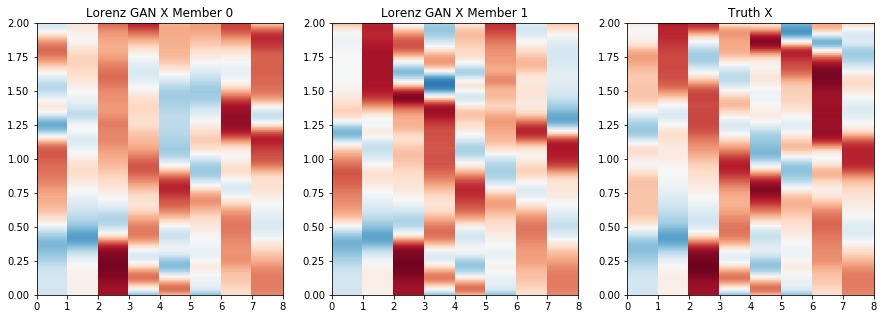

In [265]:
plt.figure(figsize=(15, 5))
mtu = np.arange(401) / 200
for i in range(2):
    plt.subplot(1,3, i + 1)
    plt.pcolormesh(np.arange(9), mtu, lorenz_gan_forecast_cube[i], vmin=-20, vmax=20, cmap="RdBu_r")
    plt.title("Lorenz GAN X Member {0}".format(i))
plt.subplot(1, 3, 3)
plt.pcolormesh(np.arange(9), mtu,x_vals[step_index:step_index + 400, :], vmin=-20, vmax=20, cmap="RdBu_r")
plt.title("Truth X")

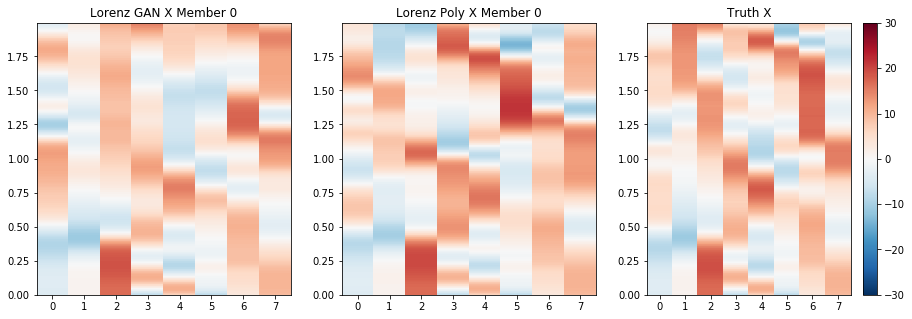

In [297]:
plt.figure(figsize=(15.5, 5))
plt.subplot(1, 3, 1)
plt.pcolormesh(np.arange(9), mtu, lorenz_gan_forecast_cube[0], vmin=-30, vmax=30, cmap="RdBu_r")
plt.xticks(np.arange(0.5, 8.5), np.arange(0, 8))
plt.title("Lorenz GAN X Member 0")
plt.subplot(1, 3, 2)
plt.title("Lorenz Poly X Member 0")
plt.pcolormesh(np.arange(9), mtu, lorenz_poly_forecast_cube[0], vmin=-30, vmax=30, cmap="RdBu_r")
plt.xticks(np.arange(0.5, 8.5), np.arange(0, 8))
plt.subplot(1, 3, 3)
plt.title("Truth X")
plt.pcolormesh(np.arange(9), mtu, x_vals[step_index:step_index + 400], vmin=-30, vmax=30, cmap="RdBu_r")
plt.xticks(np.arange(0.5, 8.5), np.arange(0, 8))
plt.colorbar()
plt.savefig("../exp_u/lorenz_forecast_x_hov.png", bbox_inches="tight", dpi=200)

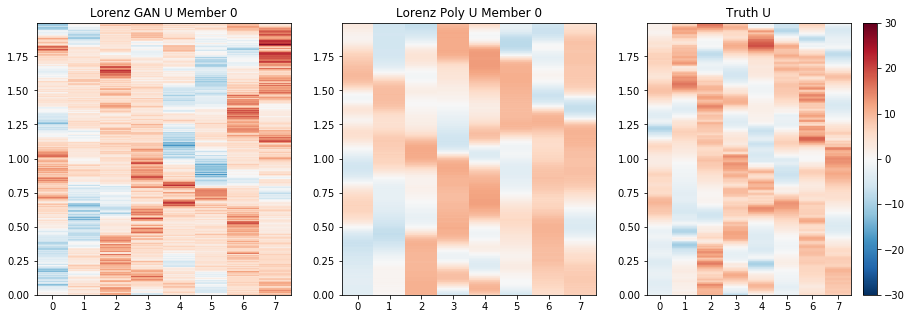

In [296]:
plt.figure(figsize=(15.5, 5))
plt.subplot(1, 3, 1)
plt.pcolormesh(np.arange(9), mtu, lorenz_gan_u_cube[0], vmin=-30, vmax=30, cmap="RdBu_r")
plt.xticks(np.arange(0.5, 8.5), np.arange(0, 8))
plt.title("Lorenz GAN U Member 0")
plt.subplot(1, 3, 2)
plt.title("Lorenz Poly U Member 0")
plt.pcolormesh(np.arange(9), mtu, lorenz_poly_u_cube[0], vmin=-30, vmax=30, cmap="RdBu_r")
plt.xticks(np.arange(0.5, 8.5), np.arange(0, 8))
plt.subplot(1, 3, 3)
plt.title("Truth U")
plt.pcolormesh(np.arange(9), mtu, u_vals[step_index:step_index + 400], vmin=-30, vmax=30, cmap="RdBu_r")
plt.xticks(np.arange(0.5, 8.5), np.arange(0, 8))

plt.colorbar()
plt.savefig("../exp_u/lorenz_forecast_u_hov.png", bbox_inches="tight", dpi=200)

(array([  46.,  165.,  513.,  427.,  488.,  653.,  555.,  261.,   77.,   15.]),
 array([-10.47444188,  -7.4878221 ,  -4.50120233,  -1.51458255,
          1.47203722,   4.45865699,   7.44527677,  10.43189654,
         13.41851632,  16.40513609,  19.39175586]),
 <a list of 10 Patch objects>)

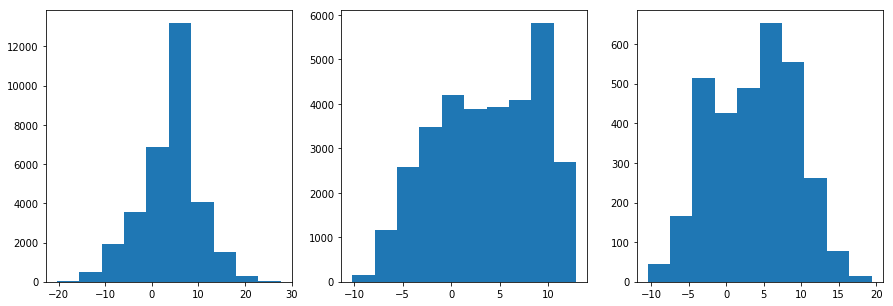

In [266]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(lorenz_gan_u_cube.ravel())
plt.subplot(1, 3, 2)
plt.hist(lorenz_poly_u_cube.ravel())
plt.subplot(1, 3, 3)
plt.hist(u_vals[step_index:step_index + 400].ravel())


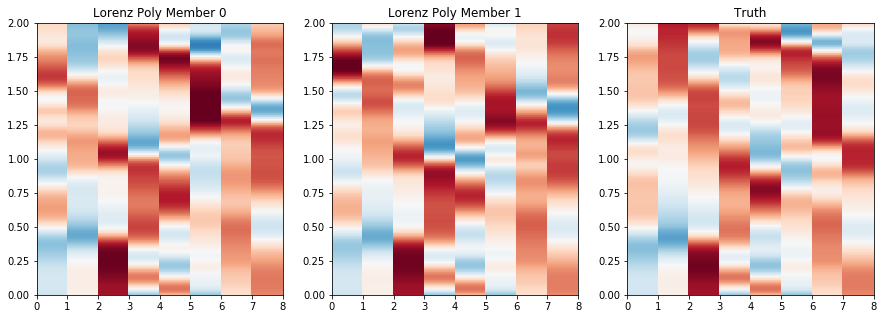

In [172]:
plt.figure(figsize=(15, 5))
mtu = np.arange(401) / 200
for i in range(2):
    plt.subplot(1,3, i + 1)
    plt.pcolormesh(np.arange(9), mtu, lorenz_poly_forecast_cube[i], vmin=-20, vmax=20, cmap="RdBu_r")
    plt.title("Lorenz Poly Member {0}".format(i))
plt.subplot(1, 3, 3)
plt.pcolormesh(np.arange(9), mtu,x_vals[step_index:step_index + 400, :], vmin=-20, vmax=20, cmap="RdBu_r")
plt.title("Truth")

In [81]:
lorenz_gan_forecast_cube[0]

array([[  2.72155571,   5.86349964,  19.90745544, ...,  10.94618988,
         10.58712673,   7.072505  ],
       [  2.81753659,   6.30469656,  19.06028938, ...,  10.65804958,
         11.04477882,   6.7737999 ],
       [  2.97192359,   6.77936029,  17.99054527, ...,  10.35089111,
         11.59599209,   6.60087824],
       ..., 
       [ -8.15293312, -12.45246601, -16.18432808, ...,  15.22755051,
        -14.79994297, -10.97614479],
       [ -8.06043434, -11.85110855, -19.03351593, ...,  11.14178658,
        -16.47936821,  -9.01316261],
       [ -8.02703476, -11.08463383, -21.58555603, ...,   6.43724871,
        -17.548666  ,  -7.30212975]])

In [274]:
mtu = np.arange(400) / 200
cmap_gan = plt.get_cmap("Blues", num_members * 2)
cmap_poly = plt.get_cmap("Greens", num_members * 2)
for x_val in range(8):
    plt.figure(figsize=(8, 6))
    for m in range(num_members):
        plt.plot(mtu, lorenz_gan_forecast_cube[m, :, x_val], color=cmap_gan(m + num_members // 2))
        plt.plot(mtu, lorenz_poly_forecast_cube[m, :, x_val], color=cmap_poly(m + num_members // 2))
    plt.plot(mtu, lorenz_gan_forecast_cube[:, :, x_val].mean(axis=0), color="blue", lw=3, label="GAN Mean")
    plt.plot(mtu, lorenz_poly_forecast_cube[:, :, x_val].mean(axis=0), color="green", lw=3, label="Poly Mean")
    plt.plot(mtu, x_vals[step_index:step_index + 400, x_val], 'k--', lw=2, label="Truth")
    plt.xlabel("Model Time Units", fontsize=14)
    plt.ylabel("X {0:d}".format(x_val), fontsize=14)
    plt.legend(loc=0, fontsize=14)
    plt.title("Lorenz Forecast Members X {0:d}".format(x_val), fontsize=18)
    plt.savefig("../exp_u/lorenz_forecast_members_{0:d}.png".format(x_val), dpi=200, bbox_inches="tight")
    plt.close()

In [272]:
x_val = 4
mtu = np.arange(400) / 200
for x_val in range(8):
    plt.figure(figsize=(8, 6))
    plt.fill_between(mtu,
                     np.percentile(lorenz_gan_forecast_cube[:, :, x_val], 99, axis=0), 
                     np.percentile(lorenz_gan_forecast_cube[:, :, x_val], 1, axis=0), 
                     color="blue", alpha=0.3, label="98% GAN CI")
    plt.plot(mtu, lorenz_gan_forecast_cube[:, :, x_val].mean(axis=0), color="blue", lw=2, label="GAN Mean")
    plt.fill_between(mtu,
                     np.percentile(lorenz_poly_forecast_cube[:, :, x_val], 99, axis=0), 
                     np.percentile(lorenz_poly_forecast_cube[:, :, x_val], 1, axis=0), 
                     color="green", alpha=0.3, label="98% Poly CI")
    plt.plot(mtu, lorenz_poly_forecast_cube[:, :, x_val].mean(axis=0), color="green", lw=3, label="Poly Mean")
    plt.plot(mtu, x_vals[step_index:step_index + 400, x_val], 'k--', lw=3, label="Truth")
    plt.xlabel("Model Time Units", fontsize=14)
    plt.ylabel("X {0:d}".format(x_val), fontsize=14)
    plt.legend(loc=0, fontsize=14)
    plt.title("Lorenz Forecast Range X {0:d}".format(x_val), fontsize=18)
    plt.savefig("../exp_u/lorenz_forecast_range_{0:d}.png".format(x_val), dpi=200, bbox_inches="tight")
    plt.close()

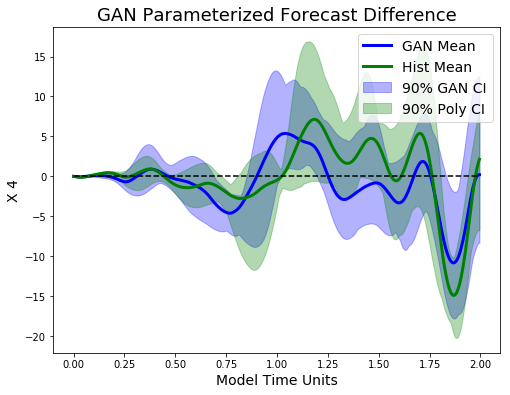

In [269]:
plt.figure(figsize=(8, 6))
x_val = 4
mtu = np.arange(400) / 200
plt.fill_between(mtu,
                 np.percentile(l_gan_fore_diff[:, :, x_val], 95, axis=0), 
                 np.percentile(l_gan_fore_diff[:, :, x_val], 5, axis=0), 
                 color="blue", alpha=0.3, label="90% GAN CI")
plt.plot(mtu, l_gan_fore_diff[:, :, x_val].mean(axis=0), color="blue", lw=3, label="GAN Mean")
plt.fill_between(mtu,
                 np.percentile(l_poly_fore_diff[:, :, x_val], 95, axis=0), 
                 np.percentile(l_poly_fore_diff[:, :, x_val], 5, axis=0), 
                 color="green", alpha=0.3, label="90% Poly CI")
plt.plot(mtu, l_poly_fore_diff[:, :, x_val].mean(axis=0), color="green", lw=3, label="Hist Mean")
plt.plot(mtu, np.zeros(mtu.shape), 'k--')
plt.xlabel("Model Time Units", fontsize=14)
plt.ylabel("X {0:d}".format(x_val), fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.title("GAN Parameterized Forecast Difference", fontsize=18)
plt.savefig("../exp/lorenz_forecast_ts_diff.png", dpi=200, bbox_inches="tight")

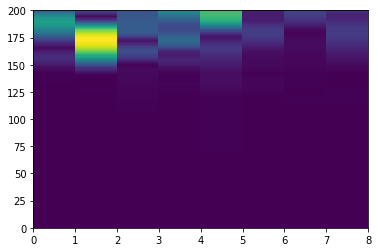

In [133]:
plt.subplots(1, 1, )
plt.pcolor(lorenz_gan_forecast_cube.std(axis=0))

In [508]:
np.percentile(lorenz_forecast_cube[:, :, x_val], 90, axis=0).shape

(201,)

In [413]:
with open("../exp/ar1_random_updater.pkl", "rb") as updater_file:
    updater = pickle.load(updater_file)

In [481]:
rand_values = np.random.normal(size=(8, 8))
all_rand_values = np.zeros((200, 8, 8))
all_rand_values[0] = rand_values
for i in range(1, 200):
    rand_values = updater.update(rand_values)
    all_rand_values[i] = rand_values

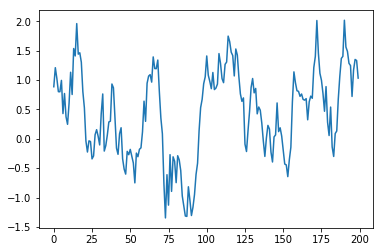

In [448]:
plt.plot(all_rand_values[:, 0, 4])

In [600]:
for i in range(10):
    print(i, pd.Series(all_rand_values[:, 0, 0]).autocorr(i))

0 1.0
1 0.900459091356
2 0.798332704409
3 0.715076477828
4 0.62945880385
5 0.537847495939
6 0.455850974727
7 0.362877812
8 0.268737670612
9 0.197284058567


In [582]:
pred_out_func = K.function(gen_model.input + [K.learning_phase()], [gen_model.output])
forcing_dist = np.zeros((1000, 8))
for i in range(1000):
    forcing_dist[i] = unnormalize_data(pred_out_func([x_vals[100000:100001].T, all_rand_values[0], True])[0], y_scaling)[:, :, 0].sum(axis=1)

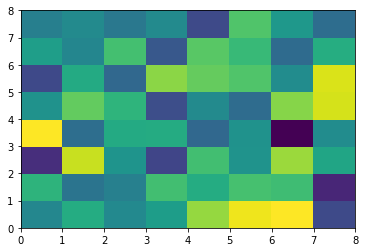

In [443]:
plt.pcolormesh(all_rand_values[1] - all_rand_values[0])

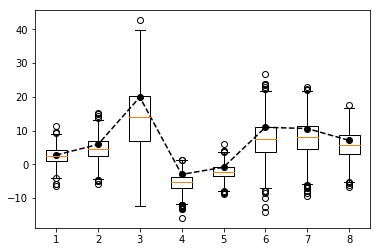

In [589]:
bx = plt.boxplot(forcing_dist)
plt.plot(np.arange(1, 9), x_vals[100000:100001].T, 'ko--')

In [468]:
print(x_vals[100000:100001,].T)

[[  2.72155571]
 [  5.86349964]
 [ 19.90745544]
 [ -3.03809571]
 [ -0.90208894]
 [ 10.94618988]
 [ 10.58712673]
 [  7.072505  ]]


In [12]:
train_data = pd.read_csv("../exp/lorenz_combined_output.csv")

In [13]:
train_data["U_t"] = train_data[train_data.columns[train_data.columns.str.contains("Y")]].sum(axis=1)

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
5          0.0
6          0.0
7          0.0
8          0.0
9          0.0
10         0.0
11         0.0
12         0.0
13         0.0
14         0.0
15         0.0
16         0.0
17         0.0
18         0.0
19         0.0
20         0.0
21         0.0
22         0.0
23         0.0
24         0.0
25         0.0
26         0.0
27         0.0
28         0.0
29         0.0
          ... 
1596770    7.0
1596771    7.0
1596772    7.0
1596773    7.0
1596774    7.0
1596775    7.0
1596776    7.0
1596777    7.0
1596778    7.0
1596779    7.0
1596780    7.0
1596781    7.0
1596782    7.0
1596783    7.0
1596784    7.0
1596785    7.0
1596786    7.0
1596787    7.0
1596788    7.0
1596789    7.0
1596790    7.0
1596791    7.0
1596792    7.0
1596793    7.0
1596794    7.0
1596795    7.0
1596796    7.0
1596797    7.0
1596798    7.0
1596799    7.0
Name: x_index, Length: 1596800, dtype: float64

In [51]:
train_data.loc[train_data["x_index"] == 3, ["U_t", "U_t-1"]]

,U_t,U_t-1
598800,1.329711,2.406654
598801,0.932690,1.329711
598802,0.761399,0.932690
598803,-0.148883,0.761399
598804,-2.133880,-0.148883
598805,-4.585677,-2.133880
598806,-6.661286,-4.585677
598807,-7.853603,-6.661286
598808,-8.169408,-7.853603
598809,-8.020258,-8.169408


(array([[    nan,     nan,     nan,     nan,     nan,     nan,     nan,
             nan,     nan,     nan],
        [    nan,     nan,     nan,     nan,    279.,   1207.,    642.,
             nan,     nan,     nan],
        [    nan,     nan,     nan,     nan,    587.,   7317.,   3107.,
             nan,     nan,     nan],
        [    nan,     nan,     nan,     nan,    383.,  20888.,   4040.,
             nan,     nan,     nan],
        [    nan,     nan,     nan,     nan,    236.,  34119.,   2782.,
             nan,     nan,     nan],
        [    nan,     nan,     nan,     nan,    741.,  33578.,   3709.,
            120.,     nan,     nan],
        [    nan,     nan,     nan,     nan,   2345.,  19266.,   5058.,
            231.,     nan,     nan],
        [    nan,     nan,     nan,    126.,   2063.,   7793.,   3954.,
            527.,     nan,     nan],
        [    nan,     nan,     nan,    137.,    824.,   1606.,   1087.,
            299.,     nan,     nan],
        [    nan,  

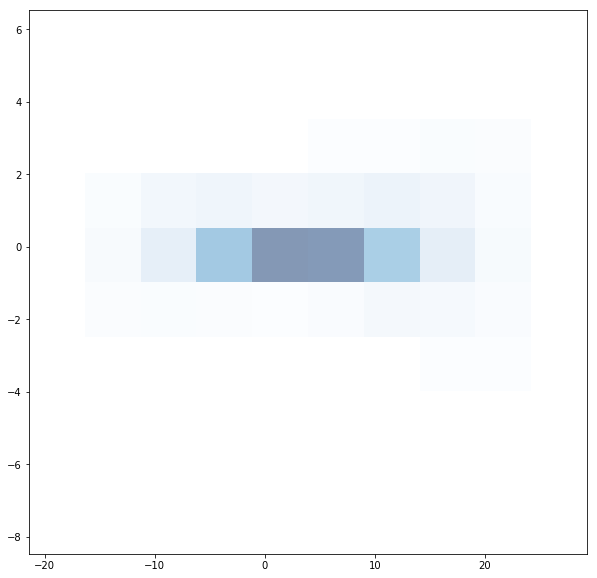

In [18]:
plt.figure(figsize=(10, 10))
plt.hist2d(train_data["X_t"], train_data["U_t-1"] - train_data["U_t"], cmin=100, cmap="Blues", alpha=0.5)


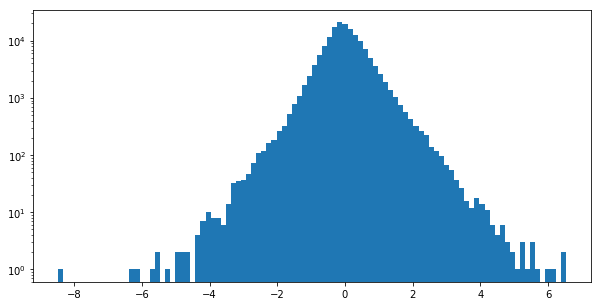

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.hist(train_data["U_t-1"] - train_data["U_t"], bins=100)
ax.set_yscale("log")

(array([[  1.,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,   1.]]),
 array([ -8.24566127,  -8.0018663 ,  -7.75807132,  -7.51427634,
         -7.27048137,  -7.02668639,  -6.78289141,  -6.53909644,
         -6.29530146,  -6.05150649,  -5.80771151,  -5.56391653,
         -5.32012156,  -5.07632658,  -4.8325316 ,  -4.58873663,
         -4.34494165,  -4.10114667,  -3.8573517 ,  -3.61355672,
         -3.36976174,  -3.12596677,  -2.88217179,  -2.63837681,
         -2.39458184,  -2.15078686,  -1.90699189,  -1.66319691,
         -1.41940193,  -1.17560696,  -0.93181198,  -0.688017  ,
         -0.44422203,  -0.20042705,   0.04336793,   0.2871629 ,
          0.53095788,   0.77475286,   1.01854783,   1.26234281,
          1.50613778,   1.74993276,   

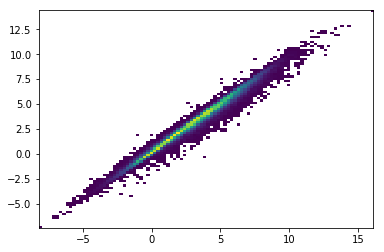

In [27]:
idx = (train_data["X_t"] >= 0) & (train_data["X_t"] < 5)
plt.hist2d(train_data.loc[idx, "U_t-1"], train_data.loc[idx, "U_t"], bins=100, cmin=1)

In [109]:
from scipy.fftpack import fft, fft2, fftfreq

In [103]:
N = 100000
T = 0.005
fx = fft(x_vals[:N, 3])
xf = np.linspace(0.0, 1.0/(2 * T), N//2)

(0, 100)

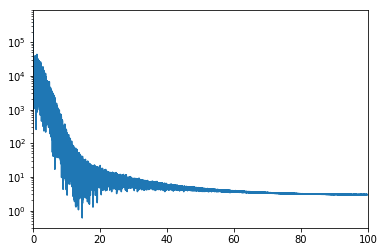

In [104]:
plt.plot(xf, np.abs(fx[:N//2]))
plt.gca().set_yscale("log")
plt.xlim(0, 100)

In [66]:
fx.shape, xf.shape

((500,), (250,))

In [105]:
fout = fft2(x_vals[:N])

(0, 10)

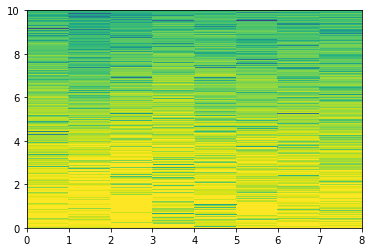

In [116]:
plt.pcolormesh(np.arange(9), fftfreq(N, 0.005)[:N//2], np.real(fout[:N//2]), vmin=0.01, norm=LogNorm(0.01, 20000))
plt.ylim(0, 10)

In [87]:
np.real(fout).max()

19647.669455685071

In [112]:
fftfreq()

<function numpy.fft.helper.fftfreq>

In [111]:
fout.shape

(100000, 8)

In [9]:
cd ..

/Users/dgagne/lorenz_gan


In [72]:
ann_model = load_ann_model("exp_20/annres_config_0005_opts.yaml")

In [73]:
mean_preds = np.zeros((10000, 1))
res_preds = np.zeros((10000, 1))
for i in range(1, mean_preds.shape[0]):
    if i % 1000 == 0:
        print(i)
    mean_preds[i], res_preds[i] = ann_model.predict(x_vals[i-1:i, 0:1], 
                                                    res_preds[i-1:i, 0:1])

1000
2000
3000
4000
5000
6000
7000
8000
9000


In [82]:
res_preds.min()

-8.3347139358520508

(array([  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.80000000e+01,   1.28500000e+03,   4.58500000e+03,
          2.91700000e+03,   9.04000000e+02,   2.15000000e+02]),
 array([-20.        , -15.55555556, -11.11111111,  -6.66666667,
         -2.22222222,   2.22222222,   6.66666667,  11.11111111,
         15.55555556,  20.        ]),
 <a list of 9 Patch objects>)

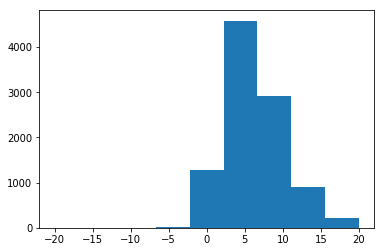

In [79]:
plt.hist(res_preds, bins=np.linspace(-20, 20, 10))

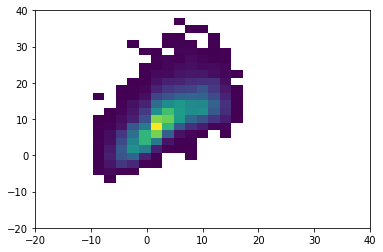

In [87]:
_ = plt.hist2d(x_vals[0:9999, 0], mean_preds[1:, 0] + res_preds[1:, 0], 
               bins=np.linspace(-20, 40, 30), cmin=1)

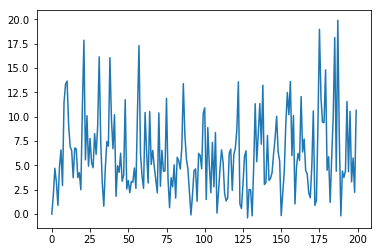

In [88]:
plt.plot(res_preds[:200])

In [90]:
np.corrcoef(res_preds[1:-2, 0], res_preds[2:-1, 0])

array([[ 1.        ,  0.24631057],
       [ 0.24631057,  1.        ]])

In [76]:
ann_model.res_predict([np.array([[0]]),np.array([[-3]]), 1])

[array([[-2.53684545]], dtype=float32)]

In [77]:
res_samples = np.zeros(1000)
for i in range(1000):
    res_samples[i] = ann_model.res_predict([x_vals[0:1, 0:1], np.array([[0]]), 1])[0]

(array([   3.,   23.,  127.,  218.,  267.,  204.,   90.,   49.,   13.,    6.]),
 array([ -4.80243587,  -3.18454914,  -1.56666241,   0.05122433,
          1.66911106,   3.2869978 ,   4.90488453,   6.52277126,
          8.140658  ,   9.75854473,  11.37643147]),
 <a list of 10 Patch objects>)

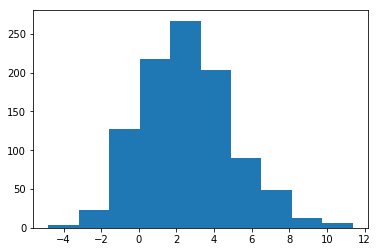

In [78]:
plt.hist(res_samples)

In [43]:
normalize_data(np.array([[0]]), scaling_values=ann_model.x_scaling_values)

NameError: name 'normalize_data' is not defined